In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
landmarks = pd.read_csv('../../Data/train.csv')
landmarks.landmark_id = landmarks.landmark_id.astype(str)
landmarks

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7
...,...,...
1580465,72c3b1c367e3d559,203092
1580466,7a6a2d9ea92684a6,203092
1580467,9401fad4c497e1f9,203092
1580468,aacc960c9a228b5f,203092


In [3]:
def get_file(id):
    root = 'C:/Users/samma/Desktop/Data science projects/landmark-recognition-2021/Data/train/'
    subfolder ='/'.join(x for x in id[0:3])
    file = '/'+id+'.jpg'
    return root+subfolder+file

In [4]:
get_file(landmarks.id[0])

'C:/Users/samma/Desktop/Data science projects/landmark-recognition-2021/Data/train/1/7/6/17660ef415d37059.jpg'

In [5]:
landmarks['file'] = landmarks.id.apply(get_file)
landmarks

,id,landmark_id,file
0,17660ef415d37059,1,C:/Users/samma/Desktop/Data science projects/l...
1,92b6290d571448f6,1,C:/Users/samma/Desktop/Data science projects/l...
2,cd41bf948edc0340,1,C:/Users/samma/Desktop/Data science projects/l...
3,fb09f1e98c6d2f70,1,C:/Users/samma/Desktop/Data science projects/l...
4,25c9dfc7ea69838d,7,C:/Users/samma/Desktop/Data science projects/l...
...,...,...,...
1580465,72c3b1c367e3d559,203092,C:/Users/samma/Desktop/Data science projects/l...
1580466,7a6a2d9ea92684a6,203092,C:/Users/samma/Desktop/Data science projects/l...
1580467,9401fad4c497e1f9,203092,C:/Users/samma/Desktop/Data science projects/l...
1580468,aacc960c9a228b5f,203092,C:/Users/samma/Desktop/Data science projects/l...


In [6]:
train, valid = train_test_split(landmarks,test_size=0.2, random_state=77)
valid=valid[~valid.landmark_id.isin(list(set(valid.landmark_id.values)-set(train.landmark_id.values)))]
print(len(train.landmark_id.value_counts()))
print(len(train))
print(len(valid.landmark_id.value_counts()))
print(len(valid))

81076
1264376
65713
315560


In [7]:
def GAP(predictions, confidence, actuals):
    total = 0
    for i in range(0,len(predictions)):
        if predictions[i] == actuals[i]:
            total += confidence[i]
    GAP = total/len(predictions)
    return GAP

In [8]:
first_100=np.sort(np.unique(landmarks.landmark_id).astype(int)).astype(str)[:100]

In [9]:
small_landmarks = landmarks[landmarks.landmark_id.isin(first_100)]

In [10]:
small_train, small_valid = train_test_split(small_landmarks,test_size=0.2, random_state=77)
small_valid=small_valid[~small_valid.landmark_id.isin(list(set(small_valid.landmark_id.values)-set(small_train.landmark_id.values)))]
small_train = small_train[~small_train.landmark_id.isin(list(set(small_train.landmark_id.values)-set(small_valid.landmark_id.values)))]
print(len(small_train.landmark_id.value_counts()))
print(len(small_train))
print(len(small_valid.landmark_id.value_counts()))
print(len(small_valid))

81
1786
81
474


In [11]:
datagen = ImageDataGenerator(rescale=1/255)
small_train_generator = datagen.flow_from_dataframe(dataframe=small_train,x_col='file', y_col='landmark_id', class_mode='categorical',
                                             target_size = (300,300), batch_size=32)
small_validation_generator = datagen.flow_from_dataframe(dataframe=small_valid, x_col='file', y_col='landmark_id', class_mode='categorical',
                                             target_size = (300,300), batch_size=32)
expanded_small_valid = np.expand_dims(np.expand_dims(small_valid, axis=2),axis=3)

Found 1786 validated image filenames belonging to 81 classes.
Found 474 validated image filenames belonging to 81 classes.


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(81, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 355216)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               181871104 
_________________________________________________________________
dense_1 (Dense)              (None, 81)                41553     
Total params: 181,913,105
Trainable params: 181,913,105
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='CategoricalCrossentropy', optimizer = 'Adam', metrics = ['Precision'])

In [16]:
history = model.fit(small_train_generator, epochs = 20, steps_per_epoch=10, validation_data=small_validation_generator, validation_steps=10)

Epoch 1/20
10/10 [==============================] - 88s 9s/step - loss: 58.6870 - precision: 0.0441 - val_loss: 20.5590 - val_precision: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 56s 6s/step - loss: 9.6917 - precision: 0.0143 - val_loss: 4.7778 - val_precision: 0.0000e+00
Epoch 3/20
10/10 [==============================] - 36s 4s/step - loss: 4.2248 - precision: 1.0000 - val_loss: 3.9653 - val_precision: 1.0000
Epoch 4/20
10/10 [==============================] - 22s 2s/step - loss: 3.7581 - precision: 0.0000e+00 - val_loss: 3.8059 - val_precision: 1.0000
Epoch 5/20
10/10 [==============================] - 21s 2s/step - loss: 3.8057 - precision: 0.7778 - val_loss: 3.7323 - val_precision: 1.0000
Epoch 6/20
10/10 [==============================] - 20s 2s/step - loss: 3.4465 - precision: 0.9286 - val_loss: 3.4139 - val_precision: 0.6818
Epoch 7/20
10/10 [==============================] - 20s 2s/step - loss: 3.2240 - precision: 0.9474 - val_loss: 3.2822 - val_precision:

In [17]:
history.history

{'loss': [58.687049865722656,
  9.691694259643555,
  4.22484827041626,
  3.7581450939178467,
  3.8057456016540527,
  3.4465243816375732,
  3.224020004272461,
  3.1756625175476074,
  2.9361515045166016,
  2.6475415229797363,
  2.5579113960266113,
  2.464637279510498,
  2.2597620487213135,
  1.9755746126174927,
  1.8810161352157593,
  1.6419013738632202,
  1.385267972946167,
  1.3194715976715088,
  1.1938738822937012,
  1.0777775049209595],
 'precision': [0.04406779631972313,
  0.014285714365541935,
  1.0,
  0.0,
  0.7777777910232544,
  0.9285714030265808,
  0.9473684430122375,
  0.8999999761581421,
  0.9268292784690857,
  0.9285714030265808,
  0.9508196711540222,
  0.9452054500579834,
  0.9135802388191223,
  0.8813559412956238,
  0.931034505367279,
  0.9375,
  0.9642857313156128,
  0.9695122241973877,
  0.9875776171684265,
  0.9735449552536011],
 'val_loss': [20.559011459350586,
  4.777846813201904,
  3.9652907848358154,
  3.8058509826660156,
  3.7322640419006348,
  3.4138875007629395,


In [18]:
predictions = model.predict(small_validation_generator)

In [19]:
pred=[]
percent = []
for prediction in predictions:
    pred.append(np.unique(small_train.landmark_id)[np.argmax(prediction)])
    percent.append(max(prediction))

In [20]:
pred

['27',
 '155',
 '43',
 '27',
 '27',
 '27',
 '27',
 '230',
 '27',
 '27',
 '145',
 '27',
 '27',
 '263',
 '27',
 '27',
 '43',
 '145',
 '192',
 '27',
 '27',
 '27',
 '27',
 '244',
 '27',
 '145',
 '230',
 '27',
 '226',
 '27',
 '192',
 '27',
 '145',
 '230',
 '27',
 '219',
 '27',
 '27',
 '27',
 '27',
 '27',
 '27',
 '192',
 '27',
 '27',
 '219',
 '27',
 '145',
 '27',
 '124',
 '226',
 '145',
 '27',
 '27',
 '230',
 '27',
 '27',
 '27',
 '27',
 '27',
 '27',
 '155',
 '136',
 '27',
 '27',
 '27',
 '27',
 '219',
 '27',
 '27',
 '27',
 '27',
 '27',
 '27',
 '139',
 '27',
 '27',
 '27',
 '27',
 '27',
 '43',
 '27',
 '219',
 '27',
 '27',
 '145',
 '27',
 '136',
 '27',
 '27',
 '27',
 '27',
 '27',
 '145',
 '145',
 '230',
 '27',
 '145',
 '230',
 '226',
 '209',
 '27',
 '230',
 '192',
 '139',
 '27',
 '27',
 '27',
 '27',
 '192',
 '230',
 '230',
 '27',
 '27',
 '192',
 '219',
 '27',
 '27',
 '27',
 '27',
 '27',
 '27',
 '226',
 '230',
 '27',
 '27',
 '27',
 '27',
 '219',
 '27',
 '27',
 '27',
 '27',
 '247',
 '27',
 '139',


In [21]:
percent

[0.64874727,
 0.25246662,
 0.12458493,
 0.8876095,
 0.9647789,
 0.28369382,
 0.53299665,
 0.16253076,
 0.5269012,
 0.7076328,
 0.52508247,
 0.8502607,
 0.8509364,
 0.061517913,
 0.10947587,
 0.96355313,
 0.24475144,
 0.13890667,
 0.23814246,
 0.7011233,
 0.36433542,
 0.14812352,
 0.50048226,
 0.529393,
 0.397535,
 0.0834497,
 0.62398374,
 0.5997011,
 0.75618607,
 0.22785424,
 0.5086963,
 0.2672879,
 0.6420982,
 0.6261259,
 0.9633248,
 0.45345914,
 0.359368,
 0.99573934,
 0.91439813,
 0.1968164,
 0.33941188,
 0.24242346,
 0.336162,
 0.68080586,
 0.26595786,
 0.19559433,
 0.30007595,
 0.49340603,
 0.44894662,
 0.34152406,
 0.6100409,
 0.15935996,
 0.933692,
 0.58599913,
 0.2955403,
 0.64734334,
 0.4727785,
 0.83634233,
 0.9988329,
 0.4174929,
 0.23734505,
 0.44311783,
 0.47240254,
 0.39973974,
 0.3364372,
 0.37752086,
 0.63096106,
 0.12967724,
 0.7827458,
 0.9917013,
 0.55266356,
 0.6107285,
 0.30616233,
 0.69218296,
 0.18369338,
 0.6568599,
 0.57643586,
 0.8745578,
 0.86050886,
 0.40667

In [22]:
GAP(pred,percent,small_valid.landmark_id.values)

0.08221062653175386

In [23]:
def generate_output(test, prediction, percentage):
    output = pd.DataFrame(list(zip(test.id, prediction, percentage)), columns=['id', 'prediction','percent'])
    output['landmarks'] = output.apply(lambda row: ' '.join([str(row.prediction),str(row.percent)]), axis=1)
    output=output[['id','landmarks']]
    return output

In [24]:
generate_output(small_valid,pred,percent)

,id,landmarks
0,f040c9262930912d,27 0.6487472653388977
1,0f48df4067e4ccd9,155 0.25246661901474
2,8e9e439157d2fc0d,43 0.12458492815494537
3,540d0cab3ab58d77,27 0.8876094818115234
4,b4d4b93a4f8fbfc4,27 0.9647789001464844
...,...,...
469,6b1491a180669de8,99 0.3845888674259186
470,fadbc8bbf259ac2e,192 0.41973692178726196
471,9a27c2f18d737148,27 0.35699909925460815
472,469f0f8679fcba63,27 0.9955645799636841


In [25]:
def plot_loss(model_history, loss_type, low = 0, high = None):
    plt.plot(range(0,len(model_history.history[loss_type][low:high])),model_history.history[loss_type][low:high], label = loss_type)
    plt.plot(range(0,len(model_history.history[loss_type][low:high])),model_history.history['val_'+loss_type][low:high], label = 'val_'+loss_type)
    plt.legend()

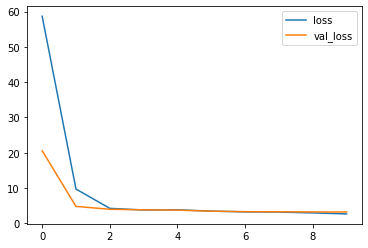

In [26]:
plot_loss(history,'loss',0,10)

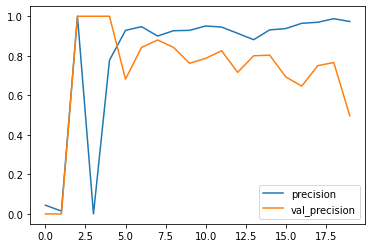

In [27]:
plot_loss(history,'precision',0,20)

In [28]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(81, activation='softmax')
])

In [29]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 85264)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               43655680  
_________________________________________________________________
dense_3 (Dense)              (None, 81)               

In [30]:
model2.compile(loss='CategoricalCrossentropy', optimizer = 'Adam', metrics = ['Precision'])

In [31]:
history2 = model2.fit(small_train_generator, epochs = 20, steps_per_epoch=10, validation_data=small_validation_generator, validation_steps=10)

Epoch 1/20
10/10 [==============================] - 17s 2s/step - loss: 7.6170 - precision: 0.1562 - val_loss: 4.1162 - val_precision: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 15s 2s/step - loss: 3.8424 - precision: 0.4762 - val_loss: 3.6235 - val_precision: 0.7500
Epoch 3/20
10/10 [==============================] - 16s 2s/step - loss: 3.4534 - precision: 0.6429 - val_loss: 3.4824 - val_precision: 1.0000
Epoch 4/20
10/10 [==============================] - 15s 1s/step - loss: 3.2381 - precision: 0.7812 - val_loss: 3.3295 - val_precision: 0.8889
Epoch 5/20
10/10 [==============================] - 15s 1s/step - loss: 2.8585 - precision: 0.8113 - val_loss: 3.3070 - val_precision: 0.6000
Epoch 6/20
10/10 [==============================] - 15s 1s/step - loss: 2.4826 - precision: 0.8202 - val_loss: 3.1290 - val_precision: 0.8116
Epoch 7/20
10/10 [==============================] - 15s 1s/step - loss: 2.3241 - precision: 0.8280 - val_loss: 3.0976 - val_precision: 0.7922
Ep

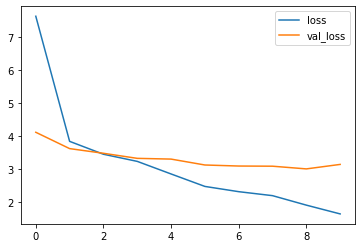

In [32]:
plot_loss(history2,'loss',0,10)

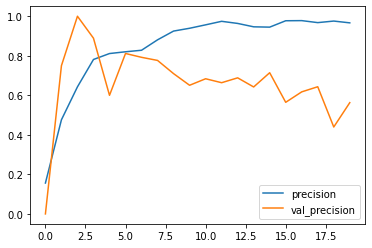

In [33]:
plot_loss(history2,'precision',0,20)

In [34]:
predictions = model2.predict(small_validation_generator)

In [35]:
pred=[]
percent = []
for prediction in predictions:
    pred.append(np.unique(small_train.landmark_id)[np.argmax(prediction)])
    percent.append(max(prediction))

In [36]:
GAP(pred,percent,small_valid.landmark_id.values)

0.07014769988472451

In [37]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(81, activation='softmax')
])

In [38]:
model3.compile(loss='CategoricalCrossentropy', optimizer = 'Adam', metrics = ['Precision'])

In [39]:
history3 = model3.fit(small_train_generator, epochs = 20, steps_per_epoch=10, validation_data=small_validation_generator, validation_steps=10)

Epoch 1/20
10/10 [==============================] - 16s 2s/step - loss: 8.1182 - precision: 0.0985 - val_loss: 3.6851 - val_precision: 0.6667
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 3.8087 - precision: 0.5000 - val_loss: 3.7293 - val_precision: 0.5172
Epoch 3/20
10/10 [==============================] - 15s 1s/step - loss: 3.5777 - precision: 0.6667 - val_loss: 3.7192 - val_precision: 0.3721
Epoch 4/20
10/10 [==============================] - 15s 1s/step - loss: 3.7287 - precision: 0.5200 - val_loss: 3.5877 - val_precision: 0.8125
Epoch 5/20
10/10 [==============================] - 15s 2s/step - loss: 3.4351 - precision: 0.4828 - val_loss: 3.4850 - val_precision: 0.7059
Epoch 6/20
10/10 [==============================] - 15s 1s/step - loss: 3.5063 - precision: 0.5652 - val_loss: 3.3980 - val_precision: 0.9286
Epoch 7/20
10/10 [==============================] - 15s 1s/step - loss: 3.2106 - precision: 0.6829 - val_loss: 3.3935 - val_precision: 0.8125
Epoch 

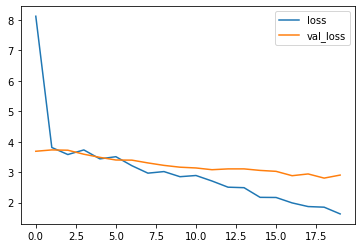

In [40]:
plot_loss(history3,'loss',0,20)

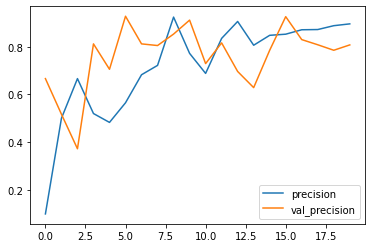

In [41]:
plot_loss(history3,'precision',0,20)

In [42]:
predictions = model3.predict(small_validation_generator)

In [43]:
pred=[]
percent = []
for prediction in predictions:
    pred.append(np.unique(small_train.landmark_id)[np.argmax(prediction)])
    percent.append(max(prediction))

In [44]:
GAP(pred,percent,small_valid.landmark_id.values)

0.0385161218260914

In [50]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(81, activation='softmax')
])
model4.compile(loss='CategoricalCrossentropy', optimizer = 'Adam', metrics = ['Precision'])
history = model4.fit(small_train_generator, epochs = 5, steps_per_epoch=10, validation_data=small_validation_generator, validation_steps=10)


Epoch 1/5
10/10 [==============================] - 322s 32s/step - loss: 100.3204 - precision: 0.0557 - val_loss: 59.6122 - val_precision: 0.2257
Epoch 2/5
10/10 [==============================] - 256s 26s/step - loss: 35.5640 - precision: 0.1211 - val_loss: 19.6433 - val_precision: 0.3725
Epoch 3/5
10/10 [==============================] - 119s 12s/step - loss: 11.4448 - precision: 0.3765 - val_loss: 7.6784 - val_precision: 0.6667
Epoch 4/5
10/10 [==============================] - 58s 6s/step - loss: 6.1540 - precision: 0.2326 - val_loss: 5.1780 - val_precision: 0.6000
Epoch 5/5
10/10 [==============================] - 80s 8s/step - loss: 4.0305 - precision: 0.8462 - val_loss: 3.9020 - val_precision: 0.5156


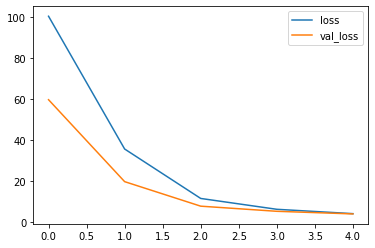

In [51]:
plot_loss(history,'loss')

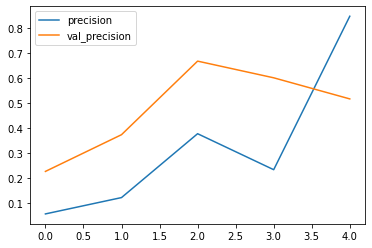

In [52]:
plot_loss(history, 'precision')

In [54]:
predictions = model4.predict(small_validation_generator)
pred=[]
percent = []
for prediction in predictions:
    pred.append(np.unique(small_train.landmark_id)[np.argmax(prediction)])
    percent.append(max(prediction))
GAP(pred,percent,small_valid.landmark_id.values)

0.06468038165839664

In [56]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(81, activation='softmax')
])
model5.compile(loss='CategoricalCrossentropy', optimizer = 'Adam', metrics = ['Precision'])
history = model5.fit(small_train_generator, epochs = 5, steps_per_epoch=10, validation_data=small_validation_generator, validation_steps=10)


Epoch 1/5
10/10 [==============================] - 106s 11s/step - loss: 13.7528 - precision: 0.0409 - val_loss: 4.5814 - val_precision: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 51s 5s/step - loss: 3.8756 - precision: 0.7059 - val_loss: 3.8214 - val_precision: 0.6000
Epoch 3/5
10/10 [==============================] - 35s 4s/step - loss: 3.6963 - precision: 0.5926 - val_loss: 3.5125 - val_precision: 0.7727
Epoch 4/5
10/10 [==============================] - 25s 3s/step - loss: 3.3727 - precision: 0.5366 - val_loss: 3.4656 - val_precision: 0.7091
Epoch 5/5
10/10 [==============================] - 21s 2s/step - loss: 3.2412 - precision: 0.7200 - val_loss: 3.2248 - val_precision: 0.7833


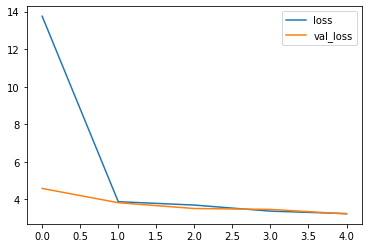

In [57]:
plot_loss(history,'loss')

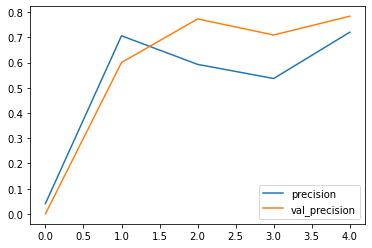

In [58]:
plot_loss(history,'precision')

In [59]:
predictions = model5.predict(small_validation_generator)
pred=[]
percent = []
for prediction in predictions:
    pred.append(np.unique(small_train.landmark_id)[np.argmax(prediction)])
    percent.append(max(prediction))
GAP(pred,percent,small_valid.landmark_id.values)

0.06470577178310745

In [60]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(81, activation='softmax')
])

In [61]:
model6.compile(loss='CategoricalCrossentropy', optimizer = 'Adam', metrics = ['Precision'])

In [62]:
history = model6.fit(small_train_generator, epochs = 10, steps_per_epoch=10, validation_data=small_validation_generator, validation_steps=10)

Epoch 1/10
10/10 [==============================] - 46s 5s/step - loss: 11.3181 - precision: 0.0761 - val_loss: 4.1208 - val_precision: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 29s 3s/step - loss: 4.1219 - precision: 0.6667 - val_loss: 3.7232 - val_precision: 1.0000
Epoch 3/10
10/10 [==============================] - 23s 2s/step - loss: 3.7738 - precision: 0.7500 - val_loss: 3.7698 - val_precision: 0.6667
Epoch 4/10
10/10 [==============================] - 21s 2s/step - loss: 3.8325 - precision: 0.4211 - val_loss: 3.7308 - val_precision: 1.0000
Epoch 5/10
10/10 [==============================] - 24s 2s/step - loss: 3.6230 - precision: 0.5294 - val_loss: 3.5353 - val_precision: 0.7500
Epoch 6/10
10/10 [==============================] - 17s 2s/step - loss: 3.5686 - precision: 0.6667 - val_loss: 3.4232 - val_precision: 0.8500
Epoch 7/10
10/10 [==============================] - 16s 2s/step - loss: 3.3167 - precision: 0.6842 - val_loss: 3.3780 - val_precision: 0.9333
E

In [63]:
predictions = model6.predict(small_validation_generator)
pred=[]
percent = []
for prediction in predictions:
    pred.append(np.unique(small_train.landmark_id)[np.argmax(prediction)])
    percent.append(max(prediction))
GAP(pred,percent,small_valid.landmark_id.values)

0.07905470617587053